# CosmoPowerJAX: differentiable emulators of cosmological power spectra

In this short walkthrough notebook, we are going to show how to use CosmoPower-JAX (CPJ), a set of neural emulators for the matter power spectrum and CMB probes.

Firstly, we make the usual imports and load a subset of the test dataset used to validate CPJ.

In [1]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
from modules.cosmopower_jax import CosmoPowerJAX as CPJ

## Using a custom `.pkl` file

In [2]:
emulator_custom_TT = CPJ(probe='custom_log', filename='cmb_neff_spt_TT_NN.pkl')
emulator_custom_TE = CPJ(probe='custom_pca', filename='cmb_neff_spt_TE_PCAplusNN.pkl')
emulator_custom_EE = CPJ(probe='custom_log', filename='cmb_neff_spt_EE_NN.pkl')

In [3]:
cosmo_params_custom1 = np.array([
    0.021,  # ombh2
    0.1,   # omch2
    0.64,   # h
    0.066,   # tau
    0.965,  # ns
    3.1,    # logA
    2.99    # neff
])

cosmo_params_custom2 = np.array([
    0.023,  # ombh2
    0.12,   # omch2
    0.80,   # h
    0.07,   # tau
    0.965,  # ns
    3.1,    # logA
    3.2    # neff
])

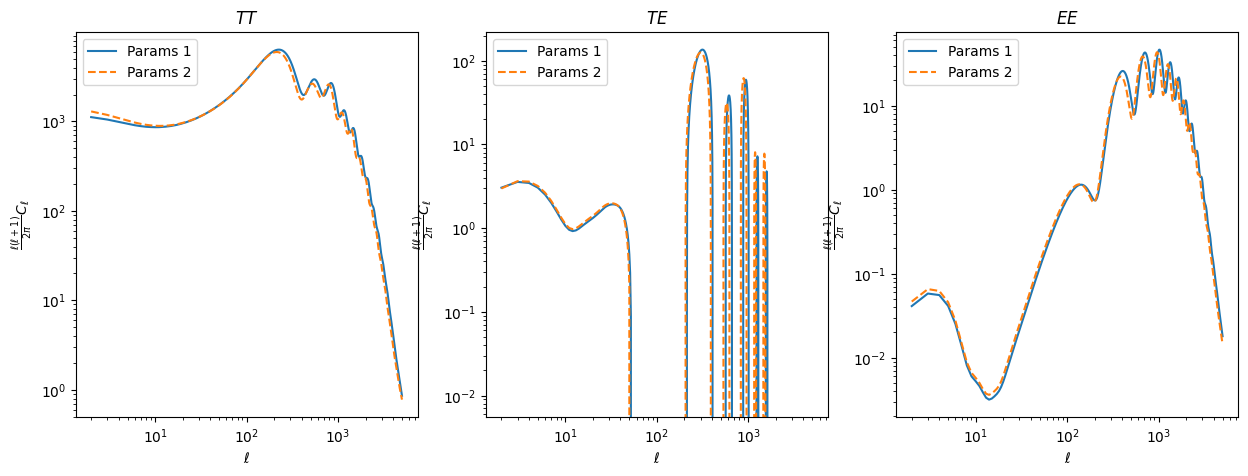

In [4]:
# Make 3 plots, TT, TE, EE, with subplots

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

ell = emulator_custom_TT.modes
axs[0].plot(ell, emulator_custom_TT.predict(cosmo_params_custom1) * ell * ( ell + 1) / (2 * np.pi), label="Params 1")
axs[0].plot(ell, emulator_custom_TT.predict(cosmo_params_custom2) * ell * ( ell + 1) / (2 * np.pi), ls='--', label="Params 2")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel('$\ell$')
axs[0].set_ylabel('$\\frac{\ell(\ell+1)}{2 \pi} C_\ell$')
axs[0].set_title("$TT$")
axs[0].legend()

ell = emulator_custom_TE.modes
axs[1].plot(ell, emulator_custom_TE.predict(cosmo_params_custom1) * ell * ( ell + 1) / (2 * np.pi), label="Params 1")
axs[1].plot(ell, emulator_custom_TE.predict(cosmo_params_custom2) * ell * ( ell + 1) / (2 * np.pi), ls='--', label="Params 2")

axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel('$\ell$')
axs[1].set_ylabel('$\\frac{\ell(\ell+1)}{2 \pi} C_\ell$')
axs[1].set_title("$TE$")
axs[1].legend()

ell = emulator_custom_EE.modes
axs[2].plot(ell, emulator_custom_EE.predict(cosmo_params_custom1) * ell * ( ell + 1) / (2 * np.pi), label="Params 1")
axs[2].plot(ell, emulator_custom_EE.predict(cosmo_params_custom2) * ell * ( ell + 1) / (2 * np.pi), ls='--', label="Params 2")

axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlabel('$\ell$')
axs[2].set_ylabel('$\\frac{\ell(\ell+1)}{2 \pi} C_\ell$')
axs[2].set_title("$EE$")
axs[2].legend()

In [5]:
import jax
import jax.numpy as np

# Dummy scalar function to test grads
def test_fn(params):
    return np.sum(emulator_custom_TE.predict(params))
    

# Test grad
jax.grad(test_fn)(cosmo_params_custom1)  # Works!

Array([ 8.7357819e+01,  1.6922811e+00, -3.1814549e+00,  8.6163559e+01,
       -4.1212051e+01,  7.2206669e+00, -5.0315730e-02], dtype=float32)

In [6]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

from likelihoods.planck2018_lite.likelihood import PlanckLitePy
import jax.numpy as np

In [7]:
# Planck2018
cosmo_params_planck = np.array([
    0.0224,  # ombh2
    0.12,   # omch2
    0.7,   # h
    0.0543,   # tau
    0.966,  # ns
    3.0448,    # logA
    3.048    # neff
])

In [8]:

ell = emulator_custom_TT.modes
units_factor = (2.7255e6) ** 2
Dltt = emulator_custom_TT.predict(cosmo_params_planck) * ell * (ell + 1) / (2 * np.pi)
Dlte = emulator_custom_TE.predict(cosmo_params_planck) * ell * (ell + 1) / (2 * np.pi)
Dlee = emulator_custom_EE.predict(cosmo_params_planck) * ell * (ell + 1) / (2 * np.pi)

# Convert to jax.numpy

Dltt = np.array(Dltt)
Dlte = np.array(Dlte)
Dlee = np.array(Dlee)

ellmin = int(ell[0]) 

plite = PlanckLitePy(year=2018, spectra="TTTEEE", ellmin=ellmin, use_low_ell_bins=False, data_directory='../likelihoods/planck2018_lite/data')

loglikelihood = plite.loglike(Dltt[:2507], Dlte[:2507], Dlee[:2507])
loglikelihood

Array(-666.15643, dtype=float32)

In [9]:
import numpy as onp

ell, Dltt, Dlte, Dlee = onp.genfromtxt("../../planck-lite-py/data/Dl_planck2015fit.dat", unpack=True)
ellmin = int(ell[0]) 
loglikelihood = plite.loglike(Dltt, Dlte, Dlee)
loglikelihood

Array(-291.33505, dtype=float32)

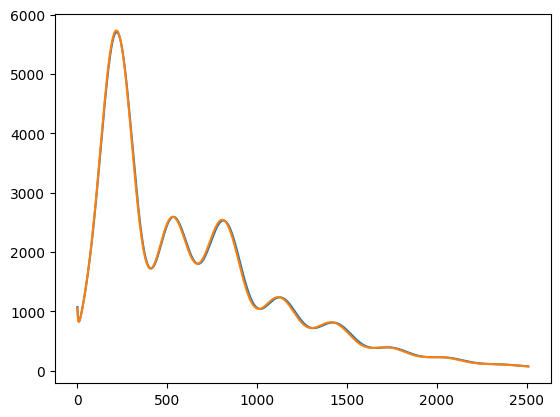

In [10]:
ell, Dltt, Dlte, Dlee = onp.genfromtxt("../../planck-lite-py/data/Dl_planck2015fit.dat", unpack=True)

plt.plot(ell, Dltt, label="TT")
ell = emulator_custom_TT.modes
plt.plot(ell[:2507], (emulator_custom_TT.predict(cosmo_params_planck) * ell * ( ell + 1) / (2 * np.pi))[:2507], label="Params 1")


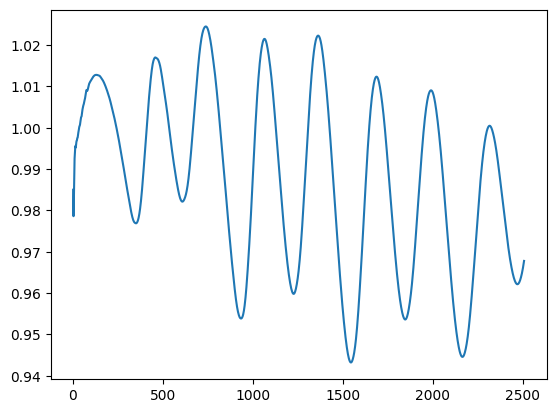

In [11]:
plt.plot(ell[:2507], (emulator_custom_TT.predict(cosmo_params_planck) * ell * ( ell + 1) / (2 * np.pi))[:2507] / Dltt, label="Params 1")

In [12]:
plite = PlanckLitePy(year=2018, spectra="TTTEEE", use_low_ell_bins=False, ellmin=ellmin, data_directory='../likelihoods/planck2018_lite/data')

In [13]:
# Minimize with scipy
from scipy.optimize import minimize

def loglike(params):
    ell = emulator_custom_TT.modes
    Dltt = emulator_custom_TT.predict(params) * ell * (ell + 1) / (2 * np.pi)
    Dlte = emulator_custom_TE.predict(params) * ell * (ell + 1) / (2 * np.pi)
    Dlee = emulator_custom_EE.predict(params) * ell * (ell + 1) / (2 * np.pi)
    return plite.loglike(Dltt, Dlte, Dlee)


In [14]:
loglike(cosmo_params_custom1)

Array(-10008.616, dtype=float32)

In [32]:
# Planck2018
cosmo_params_planck = np.array([
    0.0224,  # ombh2
    0.12,   # omch2
    0.7,   # h
    0.0543,   # tau
    0.966,  # ns
    3.0448,    # logA
    3.048    # neff
])

loglike(cosmo_params_planck)

Array(-666.15643, dtype=float32)

In [16]:
jax.grad(loglike)(cosmo_params_custom1)

Array([-781638.5  ,  871194.6  ,  148909.06 ,  137890.86 ,   -9472.825,
        -68060.516,  -16669.785], dtype=float32)

In [17]:
res = minimize(lambda x: -loglike(x), cosmo_params_planck, method='SLSQP', jac=jax.grad(loglike))

In [18]:
# Get value and loglike
res.x, -res.fun

(array([nan, nan, nan, nan, nan, nan, nan]), nan)

In [19]:
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.distributions import constraints
from numpyro.infer import Predictive, SVI, Trace_ELBO, autoguide
from numpyro.infer import MCMC, NUTS, HMC
import optax

In [51]:
def model():
    
    # Uniform priors for all parameters
    ombh2 = numpyro.sample('ombh2', dist.Uniform(0.005, 0.05))
    omch2 = numpyro.sample('omch2', dist.Uniform(0.001, 0.2))
    h = numpyro.sample('h', dist.Uniform(0.5, 0.8))
    tau = numpyro.sample('tau', dist.Uniform(0.01, 0.2))
    ns = numpyro.sample('ns', dist.Uniform(0.8, 1.2))
    logA = numpyro.sample('logA', dist.Uniform(2.7, 4))
    neff = numpyro.sample('neff', dist.Uniform(2., 4.))

    log_like = loglike(np.array([ombh2, omch2, h, tau, ns, logA, neff]))
    return numpyro.factor('log_like', log_like)


In [52]:
n_steps = 50000
lr = 1e-3

rng = jax.random.PRNGKey(42)
# guide = autoguide.AutoMultivariateNormal(model)
guide = autoguide.AutoIAFNormal(model)
optimizer = optim.optax_to_numpyro(optax.adam(lr))
svi = SVI(model, guide, optimizer, Trace_ELBO(num_particles=16),)
svi_results = svi.run(rng, n_steps)

100%|██████████| 50000/50000 [09:05<00:00, 91.67it/s, init loss: 404130.8750, avg. loss [47501-50000]: 315.5628] 


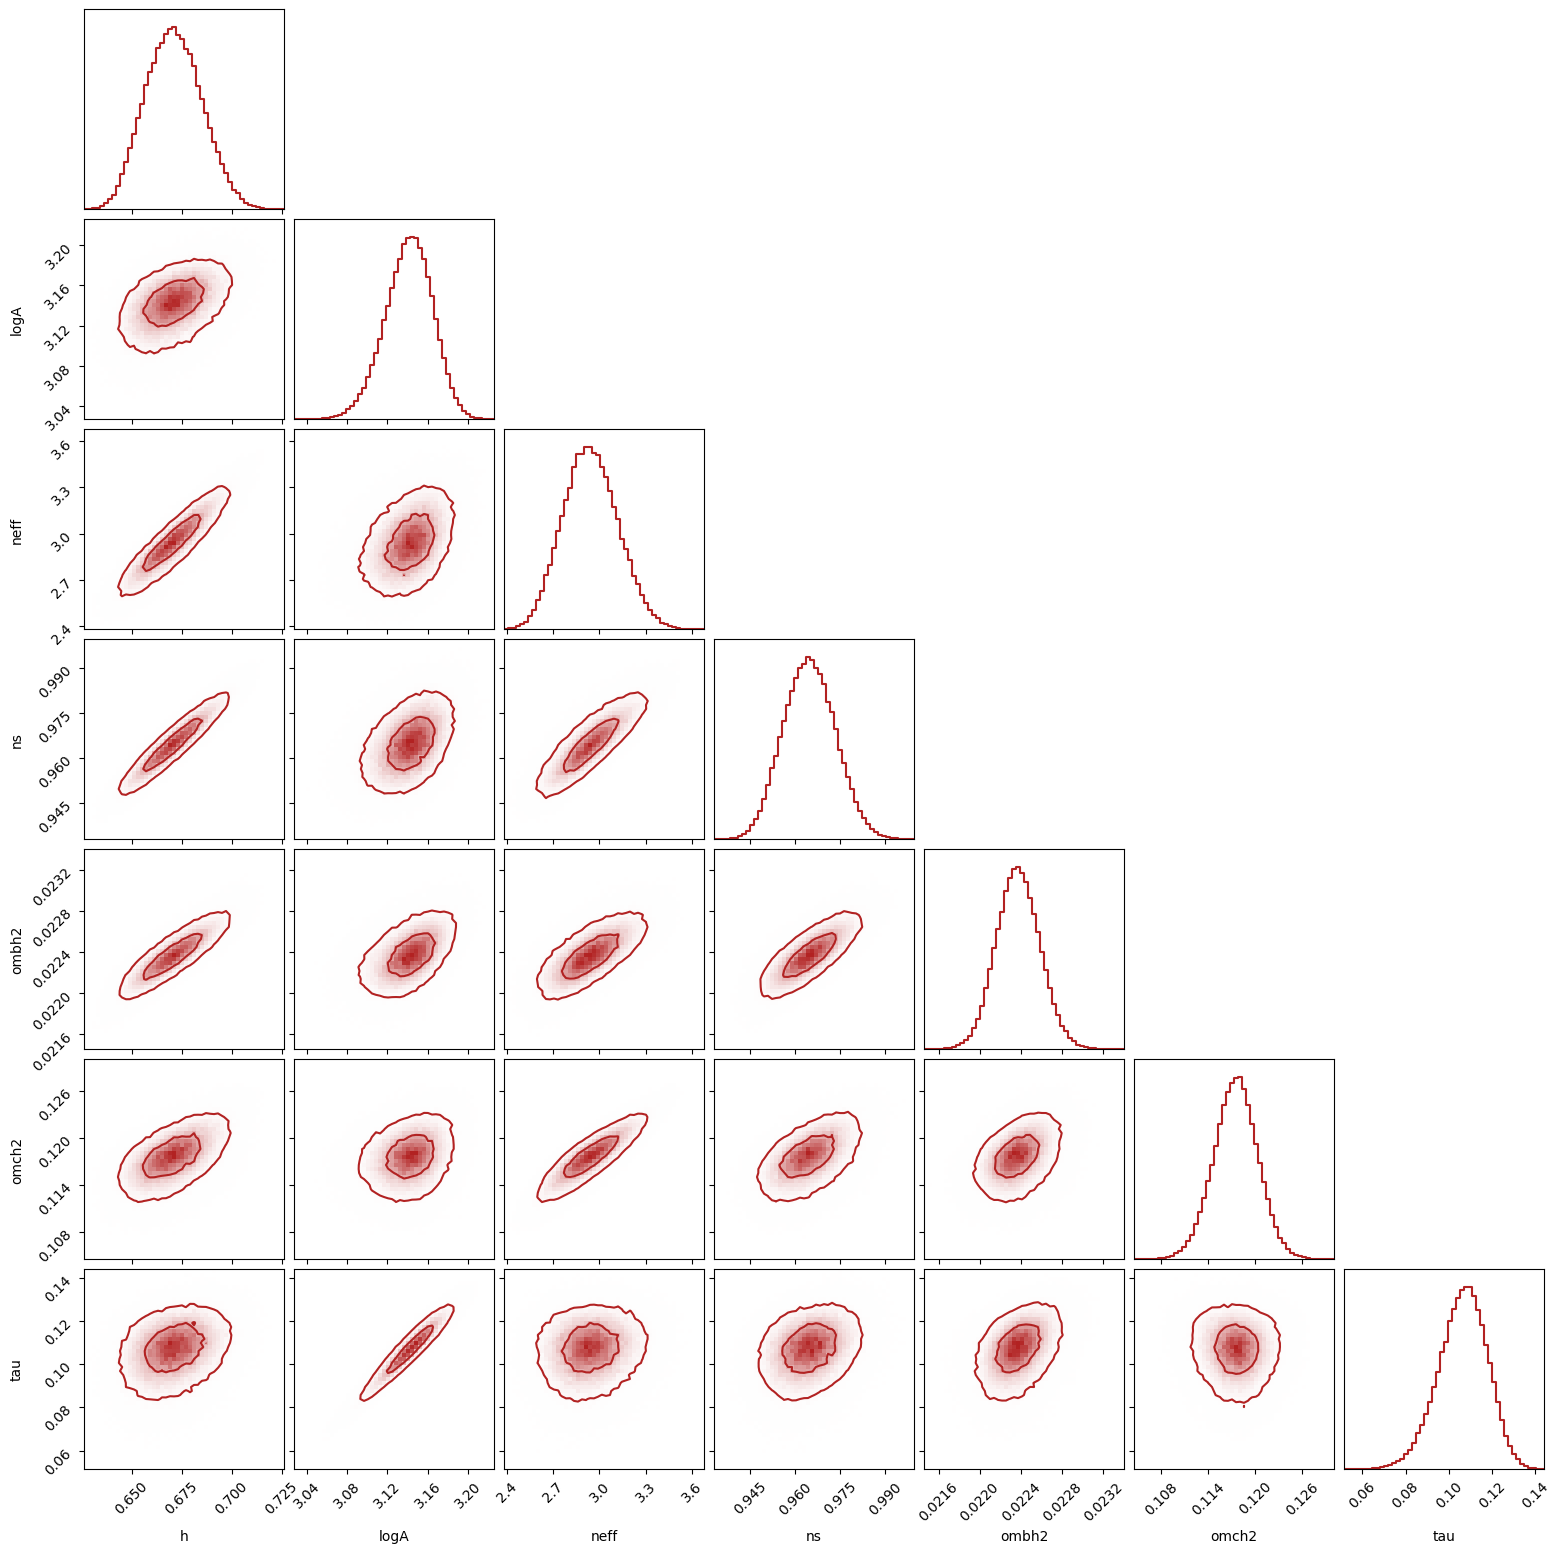

In [53]:
# Get samples and make corner plot
num_samples = 100000

rng, _ = jax.random.split(rng)
posterior_dict = guide.sample_posterior(rng_key=rng, params=svi_results.params, sample_shape=(num_samples,))

import corner
import arviz

levels =  1.0 - np.exp(-0.5 *np.array([1.0, 2.0]) ** 2)

corner_configs = {
    "smooth": 0.4,
    "smooth1d": 0.4,
    "bins": 50,
    "levels": levels, # Assuming 'levels' is defined elsewhere
    "plot_datapoints": False,
    "plot_density": True,
    "color": 'firebrick',
    # "labels": [r"$\Omega_b h^2$", r"$\Omega_c h^2$", r"$h$", r"$\tau$", r"$n_s$", r"$\log(10^{10} A_s)$", r"$N_{\rm eff}$"]
}

corner.corner(arviz.from_dict(posterior_dict), **corner_configs);

In [54]:
arviz.summary(arviz.from_dict(posterior_dict))

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h,0.671,0.014,0.646,0.697,0.000,0.0,100653.0,99543.0,NaN
logA,3.141,0.023,3.096,3.184,0.000,0.0,100479.0,99295.0,NaN
neff,2.944,0.175,2.615,3.267,0.001,0.0,100527.0,98766.0,NaN
ns,0.965,0.009,0.949,0.981,0.000,0.0,99564.0,98244.0,NaN
ombh2,0.022,0.000,0.022,0.023,0.000,0.0,99538.0,98659.0,NaN
omch2,0.118,0.003,0.112,0.123,0.000,0.0,100546.0,98186.0,NaN
tau,0.106,0.011,0.085,0.127,0.000,0.0,100446.0,100171.0,NaN


In [40]:
%%timeit 
loglike(cosmo_params_planck)

2.77 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
import emcee

def log_prior(params):
    if not (0.005 < params[0] < 0.1):
        return -np.inf
    if not (0.001 < params[1] < 0.2):
        return -np.inf
    if not (0.5 < params[2] < 0.8):
        return -np.inf
    if not (0.01 < params[3] < 0.8):
        return -np.inf
    if not (0.8 < params[4] < 1.2):
        return -np.inf
    if not (2.7 < params[5] < 4):
        return -np.inf
    if not (2. < params[6] < 4.0):
        return -np.inf
    return 0.0

def log_probability(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(params)

In [43]:
ndim, nwalkers = 7, 64
pos = np.array([cosmo_params_planck + 1e-3 * onp.random.randn(ndim) for _ in range(nwalkers)])
sampler = emcee.EnsembleSampler(nwalkers, ndim, (log_probability), vectorize=False)
sampler.run_mcmc(pos, 10000, progress=True);

flat_samples = sampler.get_chain(discard=100, flat=True)

100%|██████████| 10000/10000 [26:07<00:00,  6.38it/s]


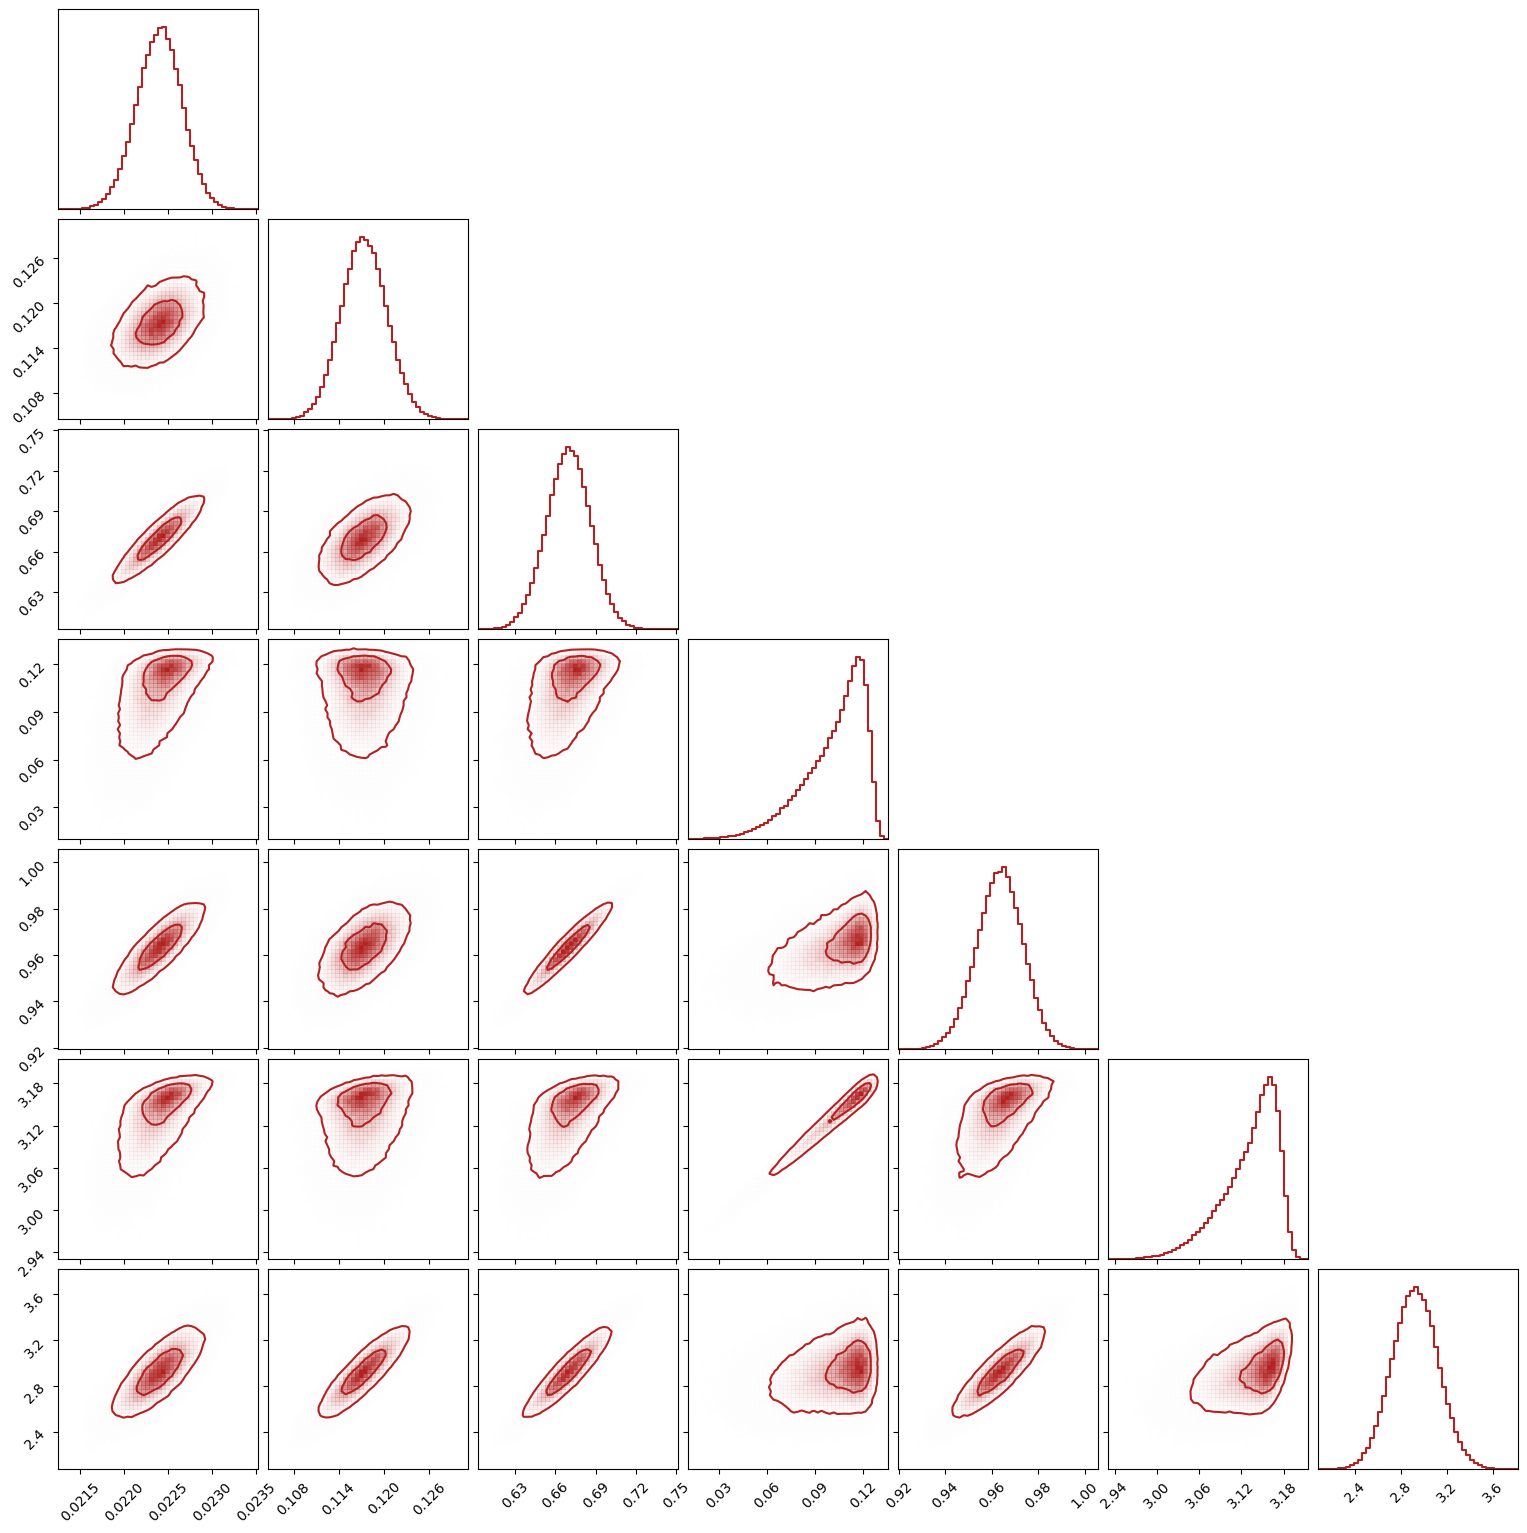

In [44]:

fig = corner.corner(
    flat_samples, **corner_configs
);

In [55]:
import arviz

posterior = arviz.from_emcee(sampler, var_names=["ombh2", "omch2", "h", "tau", "ns", "logA", "neff"])

# Summarize
arviz.summary(posterior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ombh2,0.022,0.000,0.022,0.023,0.000,0.000,7097.0,17816.0,1.01
omch2,0.117,0.003,0.112,0.123,0.000,0.000,7040.0,20220.0,1.01
h,0.670,0.016,0.639,0.701,0.000,0.000,6857.0,18572.0,1.01
tau,0.101,0.020,0.063,0.128,0.000,0.000,6120.0,12353.0,1.01
ns,0.963,0.010,0.944,0.982,0.000,0.000,6869.0,19296.0,1.01
logA,3.130,0.040,3.051,3.189,0.001,0.000,6109.0,13023.0,1.01
neff,2.923,0.201,2.545,3.299,0.002,0.002,6837.0,18088.0,1.01


In [56]:
arviz.summary(arviz.from_dict(posterior_dict))

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h,0.671,0.014,0.646,0.697,0.000,0.0,100653.0,99543.0,NaN
logA,3.141,0.023,3.096,3.184,0.000,0.0,100479.0,99295.0,NaN
neff,2.944,0.175,2.615,3.267,0.001,0.0,100527.0,98766.0,NaN
ns,0.965,0.009,0.949,0.981,0.000,0.0,99564.0,98244.0,NaN
ombh2,0.022,0.000,0.022,0.023,0.000,0.0,99538.0,98659.0,NaN
omch2,0.118,0.003,0.112,0.123,0.000,0.0,100546.0,98186.0,NaN
tau,0.106,0.011,0.085,0.127,0.000,0.0,100446.0,100171.0,NaN


## Old

In [389]:
# jax.grad(loglike)(res.x)

In [390]:

# Cltt = emulator_custom_TT.predict(cosmo_params_custom1) * ell * (ell + 1) / (2 * np.pi)
# from functools import partial

# nbintt = plite.nbintt
# blmin_TT = plite.blmin_TT
# blmax_TT = plite.blmax_TT
# plmin_TT = plite.plmin_TT
# bin_w_TT = plite.bin_w_TT

# # @partial(jax.jit, static_argnums=(1,))
# def bin_Cl(Cltt, ellmin):
#     Cltt_bin = np.zeros(plite.nbintt)

#     # Make nbintt copies of Cltt
#     Cltt = np.broadcast_to(Cltt, (nbintt, len(Cltt)))
    
#     for i in range(nbintt):
#         # Calculate indices for the operation.
#         sum_index_start = blmin_TT[i] + plmin_TT - ellmin
#         sum_index_end = blmax_TT[i] + plmin_TT + 1 - ellmin

#         # Get all unique values of (sum_index_end - sum_index_start)

#         # Use jax.lax.dynamic_slice
#         weighted_sum = np.sum(
#             # jax.lax.dynamic_slice(Cltt, [sum_index_start], [sum_index_end - sum_index_start])
#             jax.lax.dynamic_slice(Cltt[i], [sum_index_start], [sum_index_end - sum_index_start])
#         )

#         # Update Cltt_bin accumulator.
#         Cltt_bin = Cltt_bin.at[i].set(weighted_sum)

#     return Cltt_bin

# bin_Cl(Cltt, ellmin)

In [378]:
Cltt = emulator_custom_TT.predict(cosmo_params_custom1) * ell * (ell + 1) / (2 * np.pi)

from functools import partial

nbintt = plite.nbintt
blmin_TT = plite.blmin_TT
blmax_TT = plite.blmax_TT
plmin_TT = plite.plmin_TT
bin_w_TT = plite.bin_w_TT

ellmin = 2

sum_index_start = blmin_TT + plmin_TT - ellmin
sum_index_end = blmax_TT + plmin_TT + 1 - ellmin

bins_unique = np.unique(sum_index_end - sum_index_start)

bin_indices = [np.where((sum_index_end - sum_index_start) == bins_unique[j])[0] for j in range(len(bins_unique))]

@partial(jax.jit, static_argnums=(1,3,))
def bin_Cl(Cltt, ellmin, bin_indices, delta):
    Cltt_bin = np.zeros(nbintt)

    for i in bin_indices:
        
        sum_index_start = blmin_TT[i] + plmin_TT - ellmin
        
        weighted_sum =  np.sum(
                            jax.lax.dynamic_slice(Cltt, [sum_index_start], [delta]) * 
                            jax.lax.dynamic_slice(bin_w_TT, [blmin_TT[i]], [delta])
                        )

        # Update Cltt_bin accumulator.
        Cltt_bin = Cltt_bin.at[i].set(weighted_sum)

    return Cltt_bin

Cltt_bin = np.zeros(nbintt)
for i in range(len(bin_indices)):
    Cltt_bin += bin_Cl(Cltt, ellmin, bin_indices[i], int(bins_unique[i]))

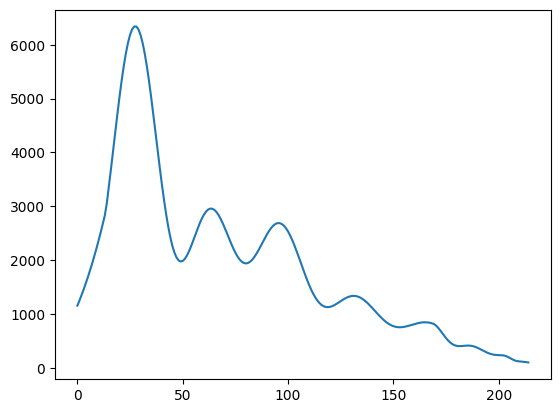

In [377]:
plt.plot(Cltt_bin)

In [374]:
%%timeit
Cltt = emulator_custom_TT.predict(cosmo_params_custom1) * ell * (ell + 1) / (2 * np.pi)
Cltt_bin = np.zeros(nbintt)
for i in range(len(bin_indices)):
    Cltt_bin += bin_Cl(Cltt, ellmin, bin_indices[i], int(bins_unique[i]))

1.75 ms ± 68.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [384]:
@partial(jax.jit, static_argnums=(0,2,4,))
def bin_Cl(plite, Cltt, ellmin, bin_indices, delta):
    Cltt_bin = np.zeros(nbintt)

    for i in bin_indices:
        
        sum_index_start = plite.blmin_TT[i] + plite.plmin_TT - ellmin
        
        weighted_sum =  np.sum(
                            jax.lax.dynamic_slice(Cltt, [sum_index_start], [delta]) * 
                            jax.lax.dynamic_slice(plite.bin_w_TT, [plite.blmin_TT[i]], [delta])
                        )

        # Update Cltt_bin accumulator.
        Cltt_bin = Cltt_bin.at[i].set(weighted_sum)

    return Cltt_bin

@partial(jax.jit, static_argnums=(0,))
def likelihood(plite, params):
    Cltt = emulator_custom_TT.predict(params) * ell * (ell + 1) / (2 * np.pi)

    blmin_TT = plite.blmin_TT
    blmax_TT = plite.blmax_TT
    plmin_TT = plite.plmin_TT

    ellmin = 2

    sum_index_start = blmin_TT + plmin_TT - ellmin
    sum_index_end = blmax_TT + plmin_TT + 1 - ellmin

    bins_unique = np.unique(sum_index_end - sum_index_start)

    bin_indices = [np.where((sum_index_end - sum_index_start) == bins_unique[j])[0] for j in range(len(bins_unique))]

    Cltt_bin = np.zeros(plite.nbintt)
    for i in range(len(bin_indices)):
        Cltt_bin += bin_Cl(plite, Cltt, ellmin, bin_indices[i], int(bins_unique[i]))

In [385]:
likelihood(plite, cosmo_params_custom1)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[645].
The error arose for the first argument of jnp.unique(). To make jnp.unique() compatible with JIT and other transforms, you can specify a concrete value for the size argument, which will determine the output size.
The error occurred while tracing the function likelihood at /var/folders/nx/bx2847k56j3dddp761x637pc0000gn/T/ipykernel_9079/552594016.py:19 for jit. This value became a tracer due to JAX operations on these lines:

  operation a:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    from line /var/folders/nx/bx2847k56j3dddp761x637pc0000gn/T/ipykernel_9079/552594016.py:29 (likelihood)

  operation a:i32[645] = add b c
    from line /var/folders/nx/bx2847k56j3dddp761x637pc0000gn/T/ipykernel_9079/552594016.py:29 (likelihood)

  operation a:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    from line /var/folders/nx/bx2847k56j3dddp761x637pc0000gn/T/ipykernel_9079/552594016.py:29 (likelihood)

  operation a:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    from line /var/folders/nx/bx2847k56j3dddp761x637pc0000gn/T/ipykernel_9079/552594016.py:30 (likelihood)

  operation a:i32[645] = add b c
    from line /var/folders/nx/bx2847k56j3dddp761x637pc0000gn/T/ipykernel_9079/552594016.py:30 (likelihood)

(Additional originating lines are not shown.)

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError